## ECON 323 Final Project
### An Analysis of Airbnb Prices Across Popular Countries in Europe


Karina Grewal (section 004), Hrithik Soni (section 003)

## Introduction
We will be looking into predicting the prices of Airbnb's in popular European destinations based on a variety of factors. As an additional quesiton we will be looking into training a classification model that tries to classify which city the Airbnb is in, based on some given factors. The dataset also includes prices when it is the weekend in comparison to weekdays. Therefore this analysis will provide much insight into social/geological factors that reveal booking trends in Airbnb's across Europe. 

## Data Description
This dataset has a wide variety of different variables to look at and create models on. Here we have a list of the variables and their descriptions. 

**The Response Variable**
* realSum (the total price of the listing)

**Independent Variables**
* room_type: the type of the accommodation 
* room_shared: dummy variable for shared rooms
* room_private: dummy variable for private rooms
* person_capacity: the maximum number of guests 
* host_is_superhost: dummy variable for superhost status
* multi: dummy variable if the listing belongs to hosts with 2-4 offers
* biz: dummy variable if the listing belongs to hosts with more than 4 offers
* cleanliness_rating: cleanliness rating
* guest_satisfaction_overall: overall rating of the listing
* bedrooms: number of bedrooms (0 for studios)
* dist: distance from city centre in km
* metro_dist: distance from nearest metro station in km
* attr_index: attraction index of the listing location
* attr_index_norm: normalised attraction index (0-100)
* rest_index: restaurant index of the listing location
* rest_index_norm: normalised restaurant index (0-100)
* lng: longitude of the listing location
* lat: latitude of the listing location

We decided to remove the following variables:

1. `guest_satisfaction_overall` as there is a chance that this rating may affect both the price of the Airbnb and the other variables in our dataset. For example if a low satisfaction score is given there is a chance that this person had a bad experience with the host and now will give a low score to the host, preventing them from becoming a superhost. To avoid this complication we are removing this variable.
2. `attr_index` and `rest_index` are being removed as we will use their normalized values listed in `attr_index_norm` and `rest_index_norm`.
3. We will also be removing `lat` and `lng` from our analysis. In our analysis we will be looking into creating a model that will try to correctly classify which city an Airbnb is listed in given a list of values for the independent variables. Therefore as the cities given in this dataset are physically very far apart these variables are essentially an answer key for the model. Therefore we remove these variables from our entire analysis. 


## Methods
We have two questions to explore in our analysis.

### Question 1: Prediction
We will be using three types of models in order to try to accurately predict the price of an Airbnb given various other values. 
1. Ordinary Least Squares Regression
2. Lasso Regression
3. Ridge Regression

### Question 2: Classification
In this portion given data on a specific Airbnb we will try to classify which city it come from given the list of cities provided in our dataset. Here is a list of the cities that are provided:

1. Amsterdam
2. Barcelona
3. Rome
4. Berlin
5. Budapest
6. Vienna
7. London
8. Lisbon
9. Athens
10. Paris

In this portion we will be using a random forest model for our analysis. 

### Reading data

In [17]:
#loading necessary packages
#!pip install opendatasets
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from pathlib import Path
import glob, os
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)
from sklearn.linear_model import (
    RidgeCV, Lasso, Ridge, LassoCV, ElasticNet
)
from sklearn.model_selection import (
    GridSearchCV, RepeatedKFold, GridSearchCV, RandomizedSearchCV, train_test_split
)
from sklearn.metrics import (
    mean_squared_error, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [2]:
#downloading datasets to a local folder
od.download("https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  karinagrewal5454


Your Kaggle Key:

  ········


100%|██████████████████████████████████████| 3.91M/3.91M [00:00<00:00, 11.0MB/s]


Our data set is spread out across many different files so a for loop was written to first read each file and then append the data. The files are separated by city and by whether the data is from a weekday or a weekend. Therefore two new columns were added to indicate which city the data line came from and which time period. 

In [4]:
#trying to download all datasets
path = r'airbnb-prices-in-european-cities' 

# Get the files from the path provided in the OP
files = Path(path).glob('*.csv')  # .rglob to get subdirectories
dfs = list()

#appending all the different files into dataframes by filename of form city_time
for i, f in enumerate(files):
    data = pd.read_csv(f, index_col=0).assign(City=os.path.basename(f).split('.')[0])
    dfs.append(data)

#Combining into a single dataframe
df = pd.concat(dfs, ignore_index=True)

#splitting the file name into two columns with city name and weekday/weekend time period separate
df[['city', 'time']] = df.City.str.split("_", expand = True)
df = df.drop('City', axis=1)

#preview
df.head()

realSum     room_type  room_shared  room_private  person_capacity  \
0  194.033698  Private room        False          True              2.0   
1  344.245776  Private room        False          True              4.0   
2  264.101422  Private room        False          True              2.0   
3  433.529398  Private room        False          True              4.0   
4  485.552926  Private room        False          True              2.0   

   host_is_superhost  multi  biz  cleanliness_rating  \
0              False      1    0                10.0   
1              False      0    0                 8.0   
2              False      0    1                 9.0   
3              False      0    1                 9.0   
4               True      0    0                10.0   

   guest_satisfaction_overall  ...      dist  metro_dist  attr_index  \
0                        93.0  ...  5.022964    2.539380   78.690379   
1                        85.0  ...  0.488389    0.239404  631.176378   
2                        87.0  ...  5.748312    3.651621   75.275877   
3                        90.0  ...  0.384862    0.439876  493.272534   
4                        98.0  ...  0.544738    0.318693  552.830324   

   attr_index_norm  rest_index  rest_index_norm      lng       lat       city  \
0         4.166708   98.253896         6.846473  4.90569  52.41772  amsterdam   
1        33.421209  837.280757        58.342928  4.90005  52.37432  amsterdam   
2         3.985908   95.386955         6.646700  4.97512  52.36103  amsterdam   
3        26.119108  875.033098        60.973565  4.89417  52.37663  amsterdam   
4        29.272733  815.305740        56.811677  4.90051  52.37508  amsterdam   

       time  
0  weekdays  
1  weekdays  
2  weekdays  
3  weekdays  
4  weekdays  

[5 rows x 21 columns]

Checking if there are any missing data in the dataset, we see that we have a complete dataset. 

In [5]:
print(df.isnull().sum())

realSum                       0
room_type                     0
room_shared                   0
room_private                  0
person_capacity               0
host_is_superhost             0
multi                         0
biz                           0
cleanliness_rating            0
guest_satisfaction_overall    0
bedrooms                      0
dist                          0
metro_dist                    0
attr_index                    0
attr_index_norm               0
rest_index                    0
rest_index_norm               0
lng                           0
lat                           0
city                          0
time                          0
dtype: int64


## Exploratory Data Analysis

#### Creating a European Map of where the data points came from

In [28]:
#Creating coordinates for geopandas to read
df["Coordinates"] = list(zip(df.lng, df.lat))
df["Coordinates"] = df["Coordinates"].apply(Point)

gdf = gpd.GeoDataFrame(df, geometry="Coordinates")

# Grab low resolution world file
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

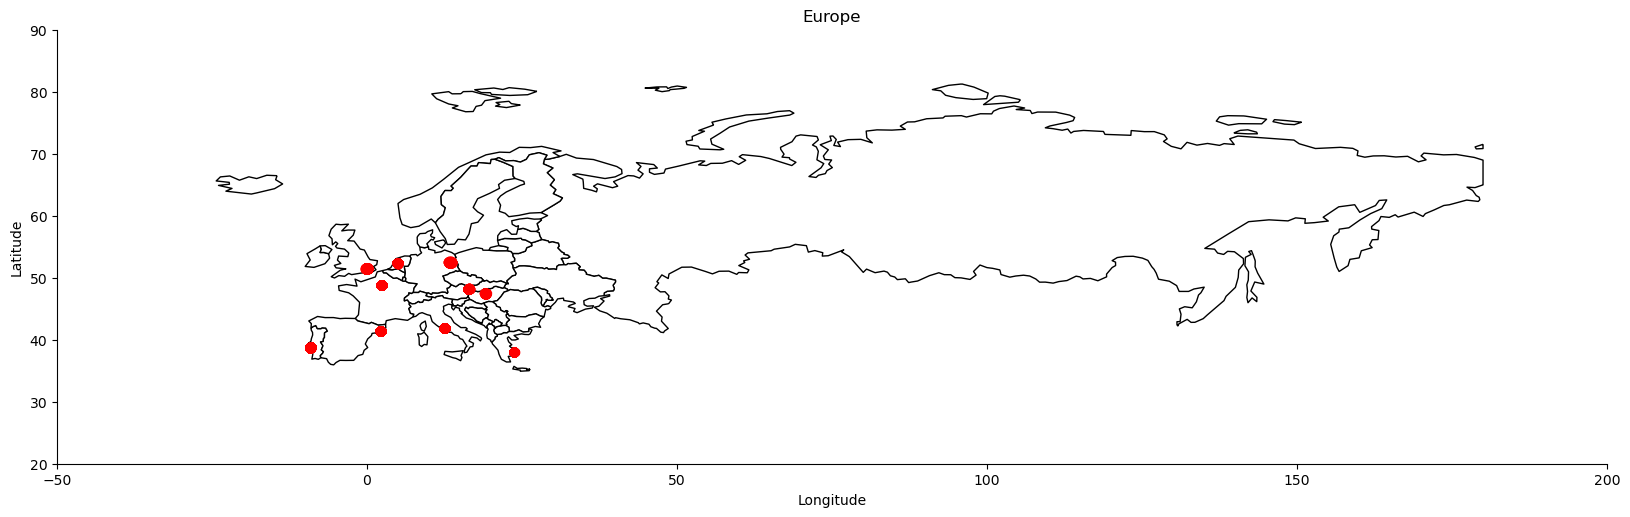

In [30]:
# Plot the cities onto the map
fig, gax = plt.subplots(figsize=(20,20))

world.query("continent == 'Europe'").plot(ax = gax, edgecolor='black', color='white')

gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('Longitude')
gax.set_ylabel('Latitude')
gax.set_title('Europe')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)
plt.xlim(-50, 200)
plt.ylim(20, 90)

# Plotting the city names
# for x, y, label in zip(gdf['Coordinates'].x, gdf['Coordinates'].y, gdf['city']):
#     gax.annotate(label, xy=(x,y), xytext=(4,4), textcoords='offset points')
    
plt.show()

### Counts of values available to us per city

(0.0, 11000.0)

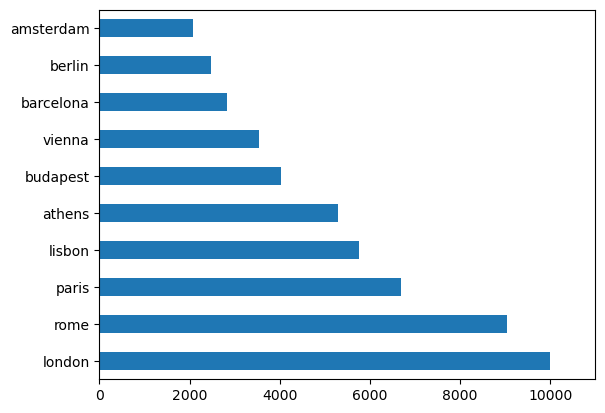

In [9]:
df["city"].value_counts().plot(kind = "barh")

plt.xlim(0, 11000)

### Plot #3: Price vs distance to city

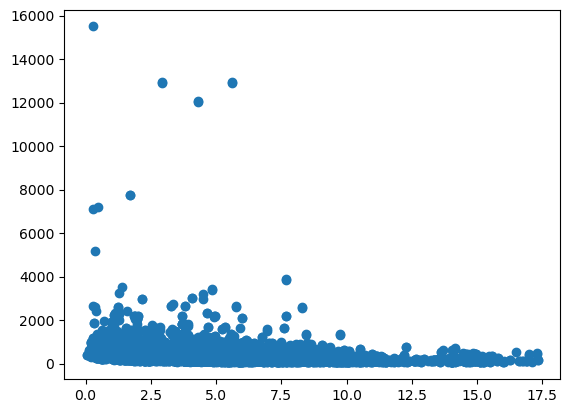

In [10]:
fig, ax = plt.subplots()

ams_rs = df.loc[df["city"] == "london"]["realSum"]
ams_cr = df.loc[df["city"] == "london"]["dist"]

ax.scatter(ams_cr, ams_rs)

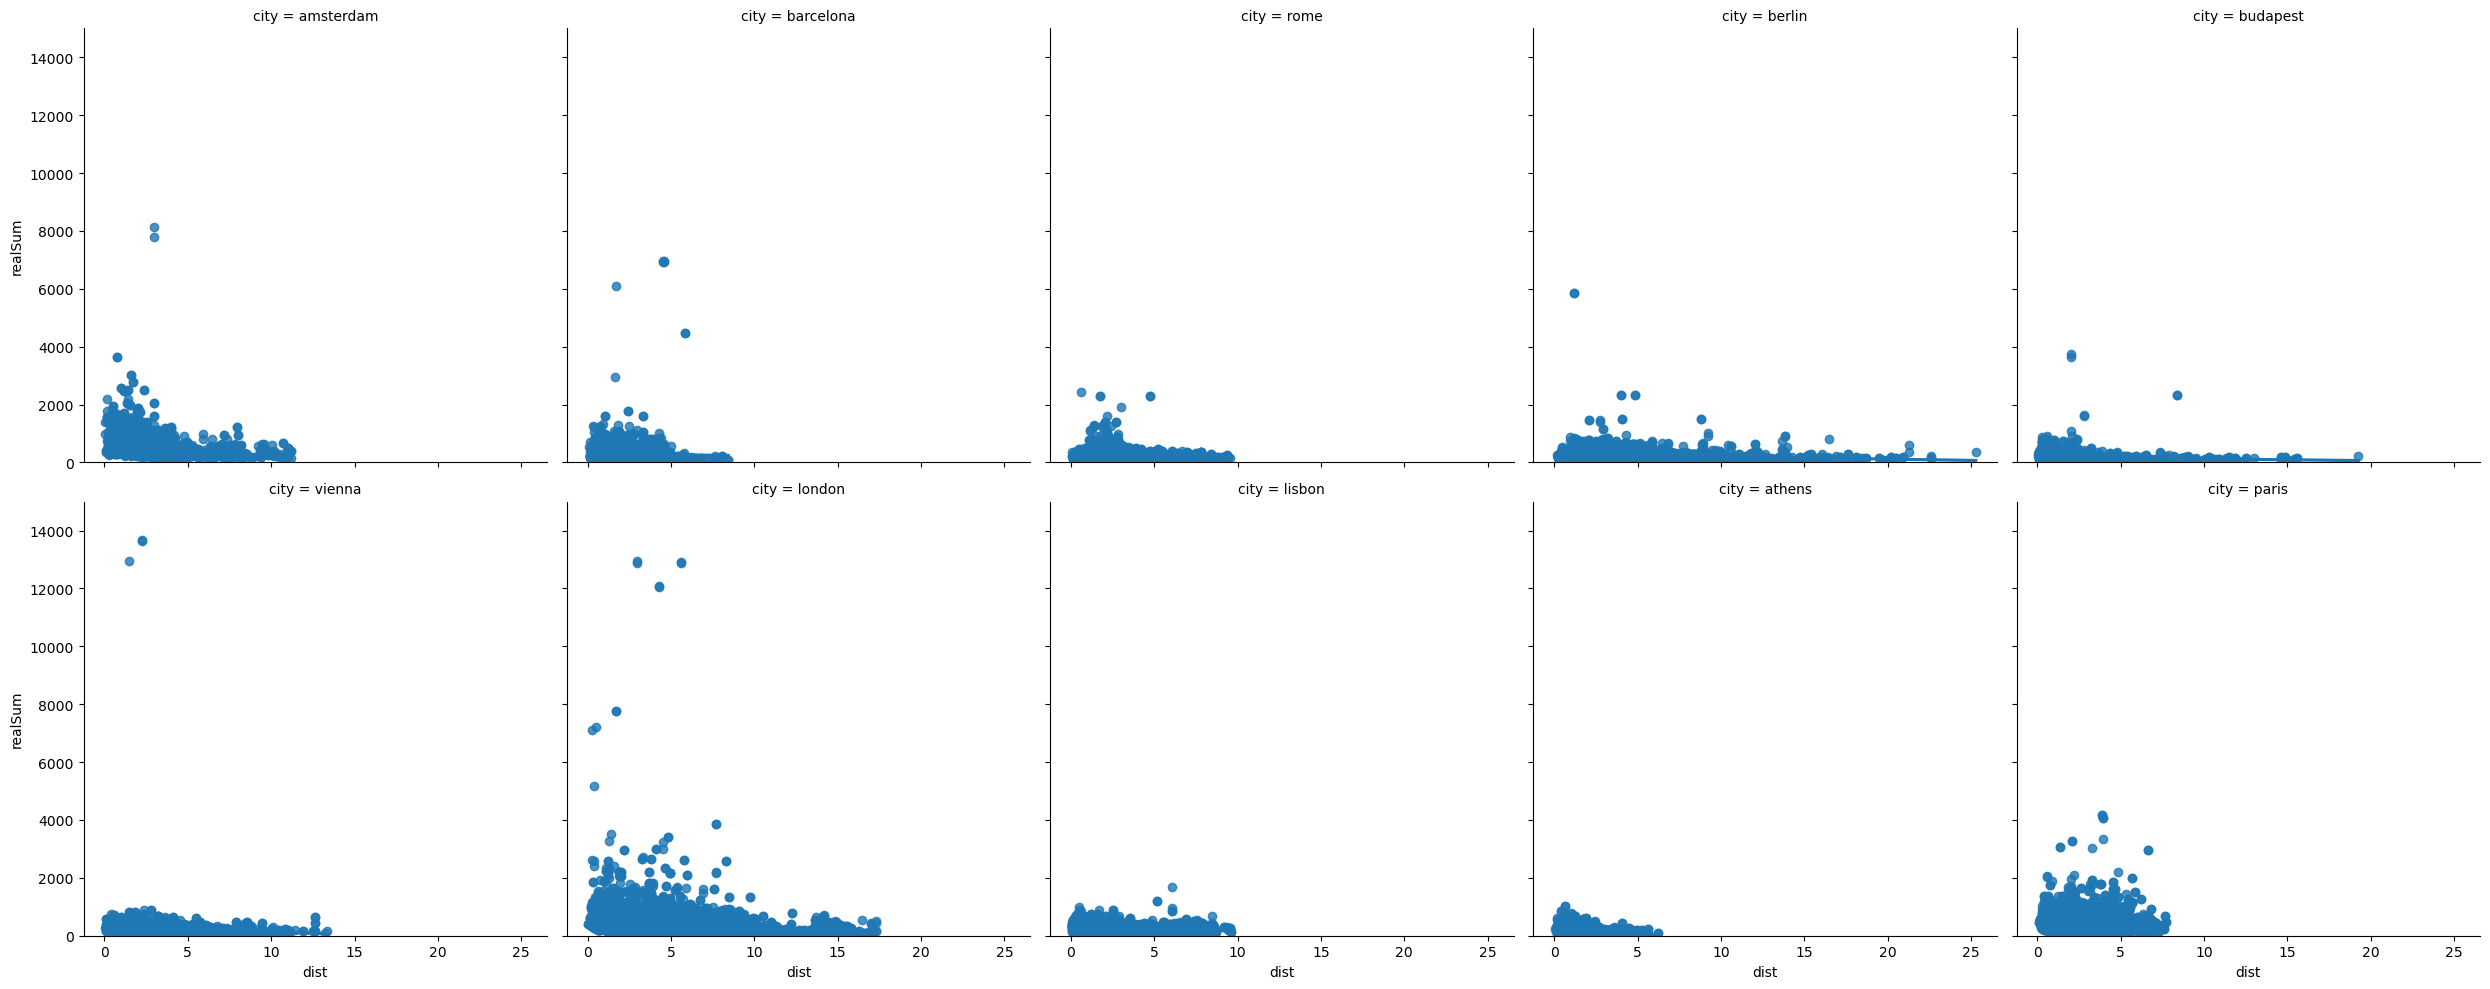

In [11]:
x = sns.lmplot(data=df, x='dist', y = 'realSum', col='city', col_wrap=5)
x.set(ylim = (0, 15000))

### Plot #4: Average price per city

<AxesSubplot:xlabel='city'>

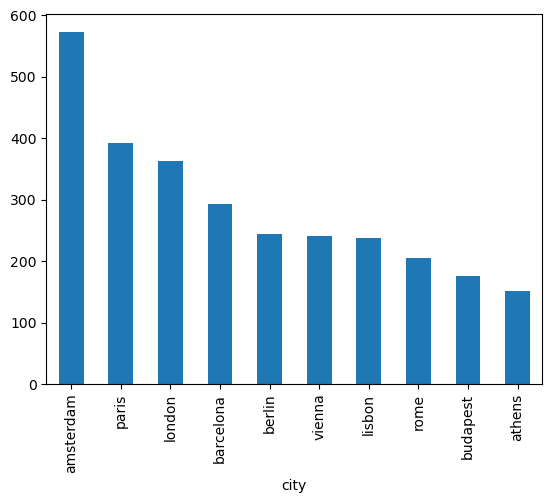

In [12]:
avg_price = df.groupby("city")["realSum"].mean()

avg_price.sort_values(ascending=False).plot.bar()

### Plot #5: Correlation heat map

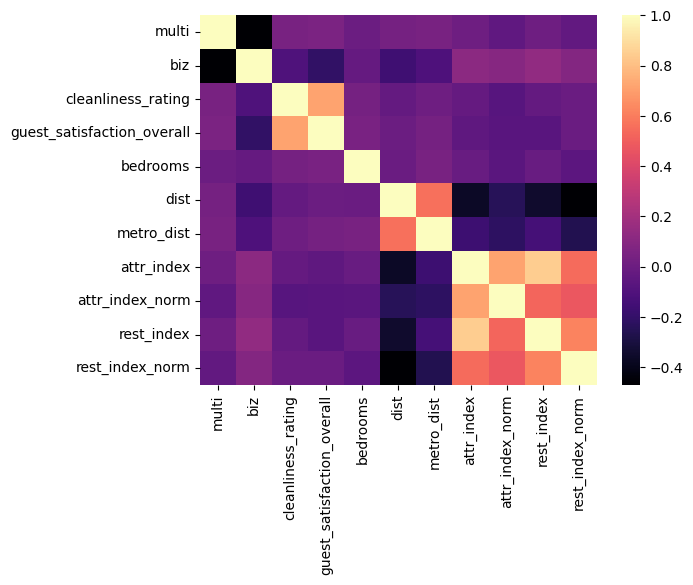

In [13]:
# Heatmap
df_heatmap = df.select_dtypes(include=np.number).iloc[:,2:-2]
df_heatmap

sns.heatmap(df_heatmap.corr(), annot = False, cmap = 'magma')
plt.show()

### Plot #6: Distribution Plot

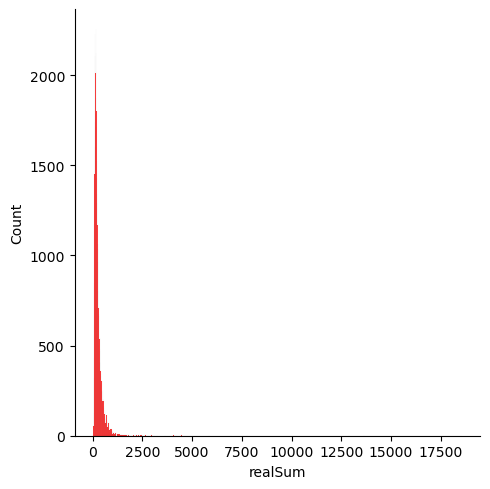

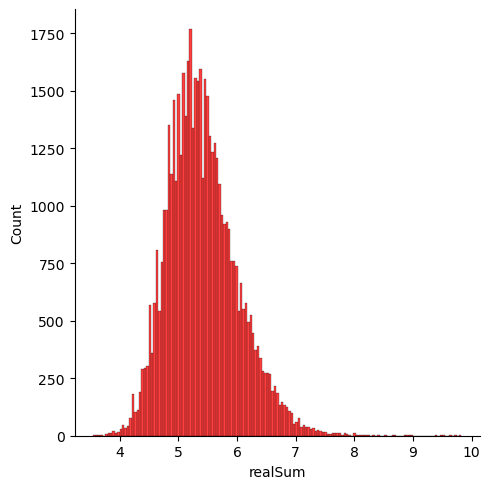

In [14]:
y = sns.displot(df['realSum'], color = 'r')

sns.displot(np.log(df['realSum']), color = 'r')

#### Plotting Continuous Variables

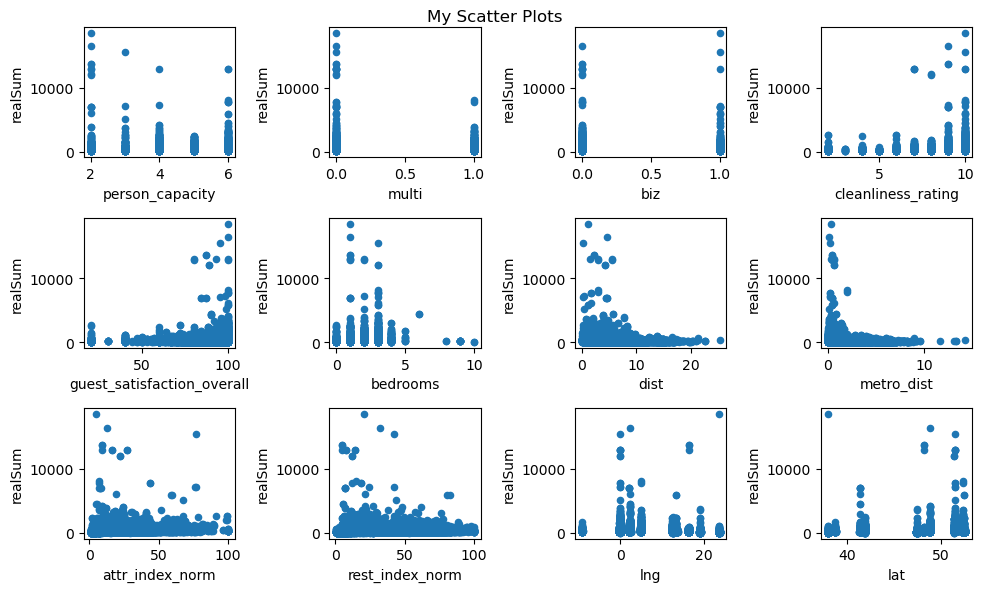

In [32]:
display_df = df[['realSum','person_capacity','multi', 'biz', 'cleanliness_rating', 
                   'guest_satisfaction_overall', 'bedrooms', 'dist',
                   'metro_dist','attr_index_norm', 'rest_index_norm', 'lng', 'lat']]

fig, ax = plt.subplots(3, 4 ,figsize=(10,6))

for i,col in enumerate(display_df.columns[1:]):
    if (i < 4):
        x = 0
        display_df.plot(kind='scatter', x=col, y='realSum', ax=ax[x, i])
    elif (i < 8):
        x = 1
        display_df.plot(kind='scatter', x=col, y='realSum', ax=ax[x, i-4])
    elif (i < 12):
        x = 2
        display_df.plot(kind='scatter', x=col, y='realSum', ax=ax[x, i-8])


fig.suptitle('My Scatter Plots')
fig.tight_layout()
fig.subplots_adjust(top=0.95)   

plt.show()

## Methods

### Prediction

#### 1. Full OLS

In [18]:
x = df.drop(["Coordinates", "realSum", "attr_index", "rest_index"], axis=1)
X = pd.get_dummies(data=x, drop_first=True)
X["host_is_superhost"] = X["host_is_superhost"].astype(int)
X = X.drop(["room_shared", "room_private", "person_capacity"], axis = 1)
Y = np.log(df["realSum"])

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.25)

airbnb_ols = linear_model.LinearRegression()
airbnb_ols.fit(X, Y)

metrics.mean_squared_error(y_test, airbnb_ols.predict(x_test))

# airbnb_ols = sm.OLS(y_train, x_train).fit()

# print(airbnb_ols.summary())

0.12574858182668003

#### 2. Forward/Backward selection

##### Feature Selection using AIC, BIC, Mallow's $C_p$, and adjusted $R^2$

In [24]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# forward
lr = linear_model.LinearRegression()

sfs = SFS(lr,
          k_features=5,
          verbose=2,
          forward = True,
          scoring='neg_mean_squared_error')

sfs = sfs.fit(x_train, y_train)

feat_names = list(sfs.k_feature_names_)
print(feat_names)

forward_xtrain_data = x_train[feat_names]
forward_xtest_data = x_test[feat_names]

forward_mod = lr.fit(forward_xtrain_data, y_train)
    
metrics.mean_squared_error(y_test, forward_mod.predict(forward_xtest_data))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.3s finished

[2023-04-09 18:35:05] Features: 1/5 -- score: -0.2797441597532741[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.4s finished

[2023-04-09 18:35:05] Features: 2/5 -- score: -0.24138080286457425[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.4s finished

[2023-04-09 18:35:05] Features: 3/5 -- score: -0.2034247040313037[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 

['bedrooms', 'attr_index_norm', 'lng', 'room_type_Private room', 'city_lisbon']


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished

[2023-04-09 18:35:06] Features: 5/5 -- score: -0.16453706170255492

0.1626493618034255

In [25]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# backward
lr = linear_model.LinearRegression()

sfs = SFS(lr,
          k_features=5,
          verbose=2,
          forward = False,
          scoring='neg_mean_squared_error')

sfs = sfs.fit(x_train, y_train)

feat_names = list(sfs.k_feature_names_)
print(feat_names)

backward_xtrain_data = x_train[feat_names]
backward_xtest_data = x_test[feat_names]

backward_mod = lr.fit(forward_xtrain_data, y_train)
    
metrics.mean_squared_error(y_test, backward_mod.predict(backward_xtest_data))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    1.5s finished

[2023-04-09 18:35:08] Features: 23/5 -- score: -0.127143511432793[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    1.4s finished

[2023-04-09 18:35:09] Features: 22/5 -- score: -0.12715966391132377[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    1.3s finished

[2023-04-09 18:35:11] Features: 21/5 -- score: -0.12718398608392578[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Do

['bedrooms', 'attr_index_norm', 'lng', 'room_type_Private room', 'city_lisbon']


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s finished

[2023-04-09 18:35:21] Features: 5/5 -- score: -0.16453706170255492

0.1626493618034255

#### 3. Lasso Regression

##### Measuring MSE of the Prediction Models

In [19]:
#defining function to report mse values for models
def fit_and_report_mses(mod, X_train, X_test, y_train, y_test):
    mod.fit(X_train, y_train)
    report = dict(
        mse_train=metrics.mean_squared_error(y_train, mod.predict(X_train)),
        mse_test=metrics.mean_squared_error(y_test, mod.predict(X_test))
    )
    return print(f"{mod} reported mse: {report}")


fit_and_report_mses(linear_model.LinearRegression(), x_train, x_test, y_train, y_test)

LinearRegression() reported mse: {'mse_train': 0.1263058160882402, 'mse_test': 0.12766020492162639}


In [20]:
fit_and_report_mses(linear_model.Lasso(), x_train, x_test, y_train, y_test)

Lasso() reported mse: {'mse_train': 0.2721481205181504, 'mse_test': 0.270167433853339}


In [21]:
#plot size
# features = df.columns[0:11]
plt.figure(figsize = (10, 10))
#add plot for ridge regression
# plt.plot(features,ridgeReg.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 10$',zorder=7)

#add plot for lasso regression
plt.plot(list(x_train), lasso_model.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'lasso; $\alpha = grid$')

#add plot for linear model
plt.plot(list(x_train), airbnb_ols.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')

#rotate axis
plt.xticks(rotation = 90)
plt.legend()
plt.title("Comparison plot of Ridge, Lasso and Linear regression model")
plt.show()

NameError: name 'lasso_model' is not defined

<Figure size 720x720 with 0 Axes>

In [ ]:
# LassoCV exploits special structure of lasso problem to minimize CV more efficiently
# lasso = linear_model.LassoCV(cv=5).fit(x_train,y_train)
# -np.log10(lasso.alpha_) # should roughly = minimizer on graph, not exactly equal due to random splitting

lasso_model = linear_model.Lasso()
lasso_model.fit(X, Y)

lasso_coefs = pd.Series(dict(zip(list(x_train), lasso_model.coef_)))
lr_coefs = pd.Series(dict(zip(list(X), airbnb_ols.coef_)))
coefs = pd.DataFrame(dict(lasso=lasso_coefs, linreg=lr_coefs))
coefs

#### 3. Lasso Regression

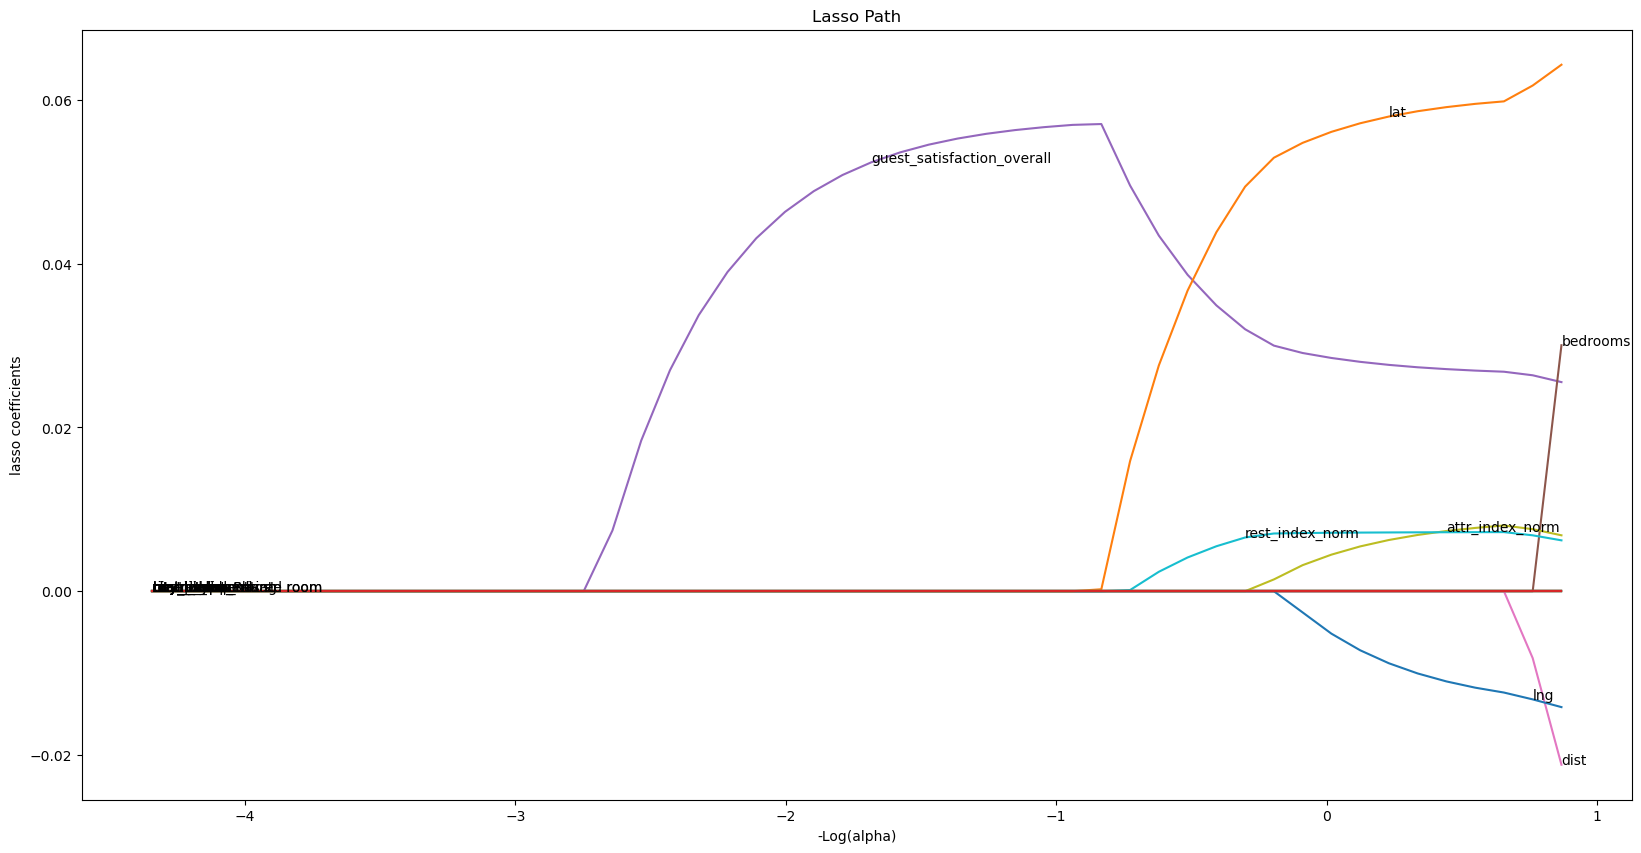

In [26]:
# alphas = np.linspace(0.01,500,100)
# lasso = Lasso(max_iter=10000)
# coefs = []

# for a in alphas:
#     lasso.set_params(alpha=a)
#     lasso.fit(x_train, y_train)
#     coefs.append(lasso.coef_)

# ax = plt.gca()

# ax.plot(alphas, coefs)
# ax.set_xscale('log')
# plt.axis('tight')
# plt.xlabel('alpha')
# plt.ylabel('Standardized Coefficients')
# plt.title('Lasso coefficients as a function of alpha');

from itertools import cycle
alphas = np.exp(np.linspace(10, -2, 50))
alphas, coefs_lasso, _ = linear_model.lasso_path(x_train, y_train, alphas=alphas, max_iter=10000)

# plotting
fig, ax = plt.subplots(figsize=(20,10))
log_alphas = -np.log10(alphas)
for coef_l, name in zip(coefs_lasso, list(x_train)):
   ax.plot(log_alphas, coef_l)
   ax.set_xlabel('-Log(alpha)')
   ax.set_ylabel('lasso coefficients')
   ax.set_title('Lasso Path')
   ax.axis('tight')
   maxabs = np.max(np.abs(coef_l))
   i = [idx for idx in range(len(coef_l)) if abs(coef_l[idx]) >= (0.9*maxabs)][0]
   xnote = log_alphas[i]
   ynote = coef_l[i]
   ax.annotate(name, (xnote, ynote))
    
def fit_and_report_mses(mod, X_train, X_test, y_train, y_test):
    mod.fit(X_train, y_train)
    return dict(
        mse_train=metrics.mean_squared_error(y_train, mod.predict(X_train)),
        mse_test=metrics.mean_squared_error(y_test, mod.predict(X_test))
    )

In [27]:
# # Lasso with 5 fold cross-validation
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# model = LassoCV(alphas=arange(0.01, 10, 0.01), cv=cv, random_state=0)

# # Fit model
# model.fit(x_train, y_train)

# print(model.alpha_)

# lasso_best = Lasso(alpha=model.alpha_)
# lasso_best.fit(x_train, y_train)

# mean_squared_error(y_test, lasso_best.predict(x_test))


lasso = linear_model.LassoCV(cv=5).fit(x_train,y_train)
-np.log10(lasso.alpha_) # should roughly = minimizer on graph, not exactly equal due to random splitting

lasso_best = Lasso(alpha=lasso.alpha_)
lasso_best.fit(x_train, y_train)

mean_squared_error(y_test, lasso_best.predict(x_test))

NameError: name 'Lasso' is not defined

(0.0021910375899684975,
 4.371694733944378,
 0.12045963021380378,
 0.37707845826974606)

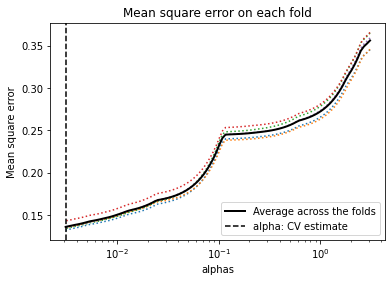

In [59]:
plt.semilogx(lasso.alphas_, lasso.mse_path_, ":")
plt.plot(
    lasso.alphas_ ,
    lasso.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    lasso.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

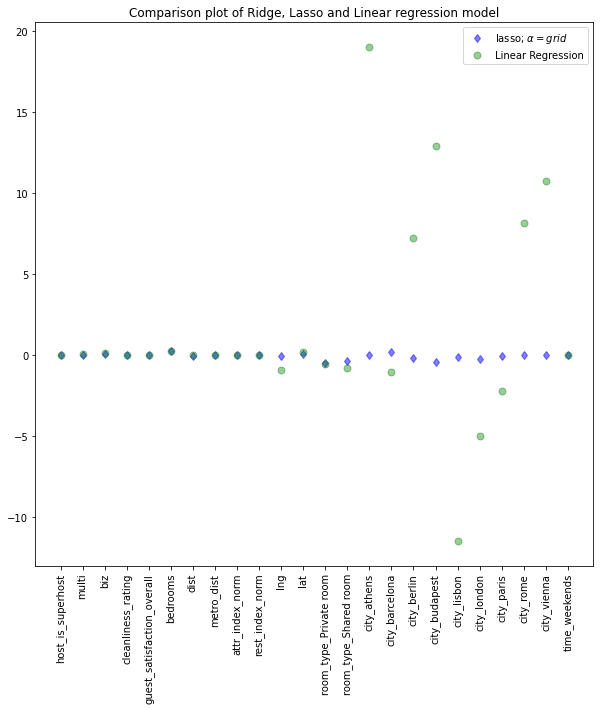

In [60]:
#plot size
# features = df.columns[0:11]
plt.figure(figsize = (10, 10))
#add plot for ridge regression
# plt.plot(features,ridgeReg.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 10$',zorder=7)

#add plot for lasso regression
plt.plot(list(x_train), lasso_best.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'lasso; $\alpha = grid$')

#add plot for linear model
plt.plot(list(x_train), airbnb_ols.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')

#rotate axis
plt.xticks(rotation = 90)
plt.legend()
plt.title("Comparison plot of Ridge, Lasso and Linear regression model")
plt.show()

#### 4. Ridge Regression

In [61]:
# Standardizing predictor variables
list_numerical = X.columns[3:12]

scaler = StandardScaler().fit(x_train[list_numerical]) 

x_train[list_numerical] = scaler.transform(x_train[list_numerical])

x_test[list_numerical] = scaler.transform(x_test[list_numerical])

x_train

host_is_superhost  multi  biz  cleanliness_rating  \
38856                  0      0    0           -3.555429   
41683                  0      1    0           -0.411323   
14124                  0      0    0            0.636713   
40522                  0      1    0            0.636713   
15171                  0      0    0            0.636713   
...                  ...    ...  ...                 ...   
11051                  0      0    0            0.636713   
38821                  0      0    0           -0.411323   
15921                  0      0    1           -0.411323   
46034                  0      0    0           -0.411323   
43814                  0      0    1           -0.411323   

       guest_satisfaction_overall  bedrooms      dist  metro_dist  \
38856                   -0.293234 -0.251723  0.849289   -0.279539   
41683                    0.041127 -0.251723 -0.539764   -0.402552   
14124                    0.821303  2.945728  0.217474   -0.411024   
40522                    0.152581 -0.251723  0.854283   -0.004393   
15171                    0.598396 -0.251723  0.797453   -0.182977   
...                           ...       ...       ...         ...   
11051                    0.821303 -0.251723 -0.484504   -0.122749   
38821                   -0.739049 -1.850449  0.603659   -0.519352   
15921                   -1.073411 -0.251723  2.289779    0.026703   
46034                   -0.404688 -0.251723 -0.733607   -0.019515   
43814                    0.041127  1.347003 -0.148688    1.698210   

       attr_index_norm  rest_index_norm  ...  city_athens  city_barcelona  \
38856        -0.175023         0.326166  ...            0               0   
41683         0.346849        -0.008583  ...            0               0   
14124         0.876933        -0.521720  ...            0               0   
40522        -0.701417        -1.172444  ...            0               0   
15171         0.468034        -0.734156  ...            0               0   
...                ...              ...  ...          ...             ...   
11051         0.166989        -1.033214  ...            0               0   
38821         0.547326         0.875967  ...            0               0   
15921        -0.452524        -0.989693  ...            0               0   
46034        -0.791059        -0.290713  ...            0               0   
43814        -1.020911        -0.654251  ...            0               0   

       city_berlin  city_budapest  city_lisbon  city_london  city_paris  \
38856            0              0            0            0           1   
41683            0              1            0            0           0   
14124            0              0            0            1           0   
40522            0              0            0            0           0   
15171            0              0            0            1           0   
...            ...            ...          ...          ...         ...   
11051            0              0            0            0           0   
38821            0              0            0            0           1   
15921            0              0            0            1           0   
46034            0              0            1            0           0   
43814            0              0            1            0           0   

       city_rome  city_vienna  time_weekends  
38856          0            0              0  
41683          0            0              1  
14124          0            0              0  
40522          0            1              1  
15171          0            0              0  
...          ...          ...            ...  
11051          0            1              0  
38821          0            0              0  
15921          0            0              0  
46034          0            0              0  
43814          0            0              0  

[38780 rows x 24 columns]

In [62]:
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# model = RidgeCV(alphas = arange(0.1, 10, 0.1), cv=cv, scoring='neg_mean_absolute_error')

# model.fit(x_train, y_train)

# print(model.alpha_)

# # Fit model
# ridge_best = Ridge(alpha = model.alpha_)
# ridge_best.fit(x_train, y_train)

# ridge_best = Ridge(alpha=model.alpha_)
# ridge_best.fit(x_train, y_train)

# mean_squared_error(y_test, ridge_best.predict(x_test))


ridge = linear_model.RidgeCV(cv=5).fit(x_train,y_train)
-np.log10(ridge.alpha_) # should roughly = minimizer on graph, not exactly equal due to random splitting

ridge_best = Ridge(alpha=ridge.alpha_)
ridge_best.fit(x_train, y_train)

mean_squared_error(y_test, ridge_best.predict(x_test))

0.12338764446628336

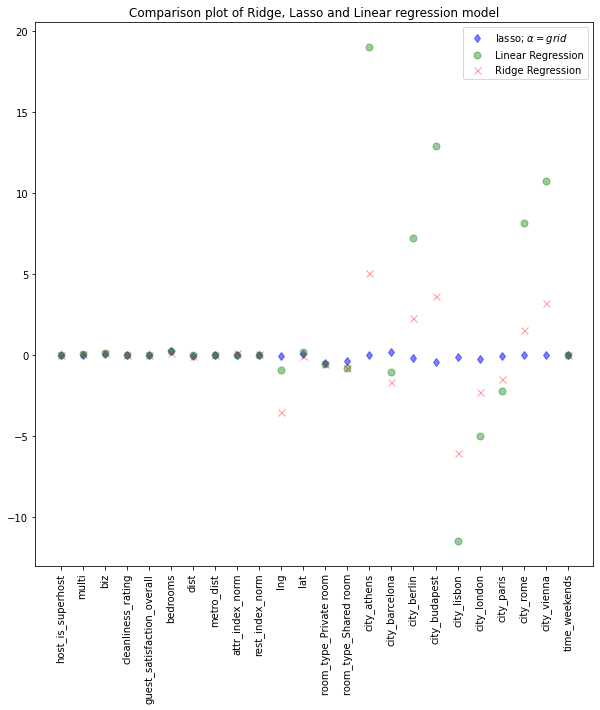

In [63]:
#plot size
# features = df.columns[0:11]
plt.figure(figsize = (10, 10))
#add plot for ridge regression
# plt.plot(features,ridgeReg.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 10$',zorder=7)

#add plot for lasso regression
plt.plot(list(x_train), lasso_best.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'lasso; $\alpha = grid$')

#add plot for linear model
plt.plot(list(x_train), airbnb_ols.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')

#add plot for ridge model
plt.plot(list(x_train), ridge_best.coef_,alpha=0.4,linestyle='none',marker='x',markersize=7,color='red',label='Ridge Regression')

#rotate axis
plt.xticks(rotation = 90)
plt.legend()
plt.title("Comparison plot of Ridge, Lasso and Linear regression model")
plt.show()

#### 5. Elastic Net

In [30]:
# from sklearn.linear_model import ElasticNetCV
# from sklearn.model_selection import RepeatedKFold

# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# # define model
# ratios = np.arange(0, 1, 0.01)
# alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
# model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)
# # fit model
# model.fit(x_train, y_train)
# # summarize chosen configuration
# print('alpha: %f' % model.alpha_)
# print('l1_ratio_: %f' % model.l1_ratio_)


/Users/hrithiksoni/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:620: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/hrithiksoni/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:620: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/hrithiksoni/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:620: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/hrithiksoni/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/

alpha: 0.000000
l1_ratio_: 0.000000


/Users/hrithiksoni/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.474e+03, tolerance: 1.382e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


1. Forward/Backward selection
2. Ridge/Lasso/Elastic Net Regression
3. Classification: Random forests (Evaluate using ROC/AUC)

### Classification

#### 1. Random Forest

In [ ]:
x = df.drop(["Coordinates", "realSum", "city", "attr_index", "rest_index", "lat", "lng"], axis=1)
X = pd.get_dummies(data=x, drop_first=True)
X["host_is_superhost"] = X["host_is_superhost"].astype(int)
X = X.drop(["room_shared", "room_private", "person_capacity"], axis = 1)
Y = df["city"]

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.25)

In [ ]:
param_dist = {'n_estimators': randint(50, 300),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)


In [ ]:
# Fit the random search object to the data
rand_search.fit(x_train, y_train)

In [ ]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

In [ ]:
# Generate predictions with the best model
y_pred = best_rf.predict(x_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

##### Plotting the first three decision trees

In [ ]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=x_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [ ]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=x_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

In [ ]:
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(best_rf, x_test, y_test, ax=ax, alpha=0.8)
svc_disp.plot(ax=ax, alpha=0.8)
plt.show()